# Implementation of clustering methods

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster as cluster
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples

#### Let's generate some data:

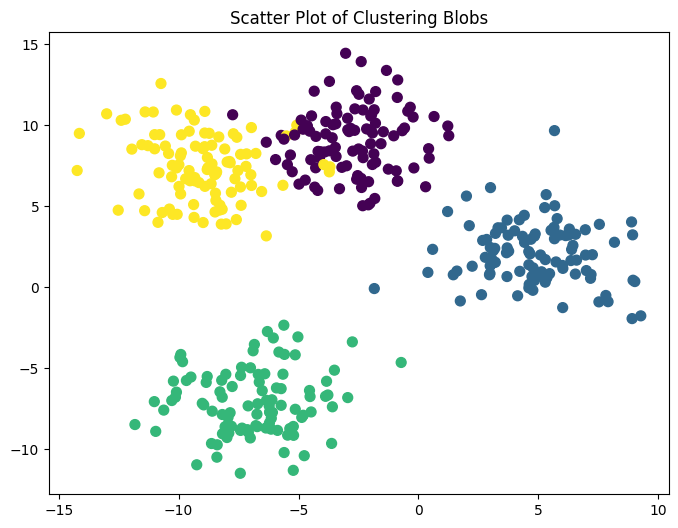

In [9]:
X, y = make_blobs(n_samples=400, centers=4, cluster_std=2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50)
plt.title('Scatter Plot of Clustering Blobs')
plt.show()

#### Let's predict the clusters using k-means, and plot the silhouette coefficent values.

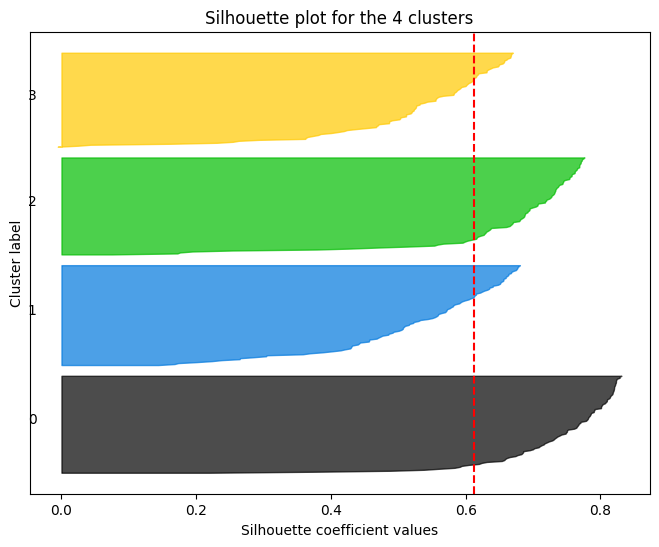

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=4, random_state=50)
y_kmeans = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, y_kmeans)
silhouette_values = silhouette_samples(X, y_kmeans)

# Plotting silhouette scores
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = silhouette_values[y_kmeans == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / 4)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax.set_title(f'Silhouette plot for the 4 clusters')
ax.set_xlabel('Silhouette coefficient values')
ax.set_ylabel('Cluster label')
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([]) 
plt.show()

#### We can see that the blue cluster is classified the worst, the the brown the best.

### DBSCAN
#### instead of k-means, we can run DBSCAN:

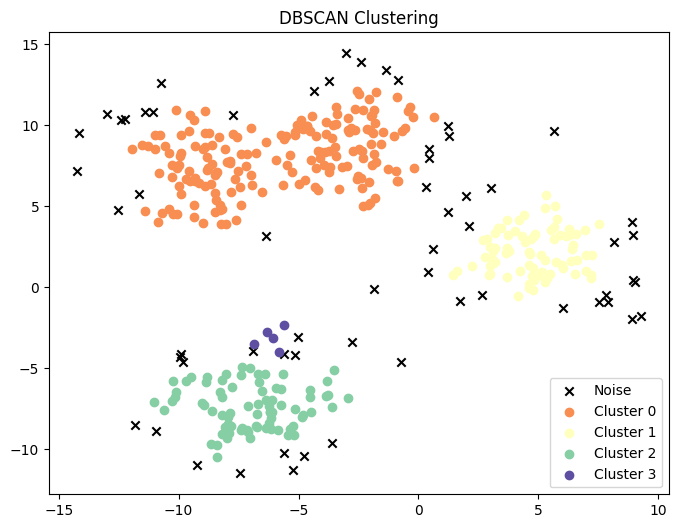

In [16]:
from sklearn.cluster import DBSCAN

# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)
y_dbscan = dbscan.fit_predict(X)

# plotting the results
plt.figure(figsize=(8, 6))
unique_labels = np.unique(y_dbscan)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points are labeled as -1 by DBSCAN
        color = 'k'
        marker = 'x'
    else:
        marker = 'o'
    
    class_member_mask = (y_dbscan == label)
    xy = X[class_member_mask]
    
    plt.scatter(xy[:, 0], xy[:, 1], c=[color], marker=marker, label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


#### And plotting the sillhoutte score again:

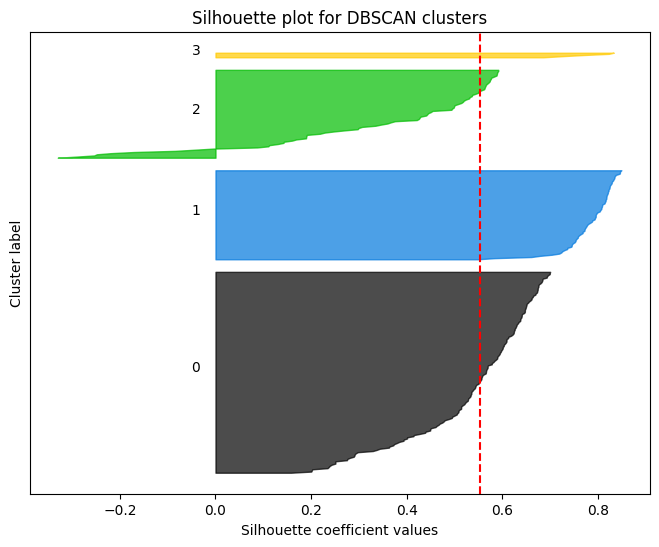

In [17]:
# We exclude the noise points (-1) for silhouette calculation because silhouette score doesn't handle them
mask = y_dbscan != -1
silhouette_avg = silhouette_score(X[mask], y_dbscan[mask])
silhouette_values = silhouette_samples(X[mask], y_dbscan[mask])


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
y_lower = 10
for i, label in enumerate(np.unique(y_dbscan[mask])):
    ith_cluster_silhouette_values = silhouette_values[y_dbscan[mask] == label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / len(np.unique(y_dbscan[mask])))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
    
    y_lower = y_upper + 10

ax.set_title(f'Silhouette plot for DBSCAN clusters')
ax.set_xlabel('Silhouette coefficient values')
ax.set_ylabel('Cluster label')
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([]) 
plt.show()


#### we can see that overall, the blue if pretty precise, and except for number of points so is green.

#### Notice that we just set epsilon as 1 by just guessing. but, we have a way to find the best epsilon for our data.

## Optuna

#### We set a range for epsilon, and we set what is the metric by which we determine who is the best epsilon

In [35]:
def objective(trial):
    eps = trial.suggest_float("eps", 0.01, 3.0)
    min_samples = trial.suggest_int("min_samples", 2, 10)
    
    # Apply DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_std)
    
    # Count the number of unique clusters formed (excluding noise)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Avoid cases where DBSCAN fails to find multiple clusters
    if n_clusters <= 1:
        return -1.1
        
    score = silhouette_score(X_std, labels)
    return score

# Run Optuna optimization again with updated parameters and objective
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-08-27 18:20:48,796] A new study created in memory with name: no-name-eb1a825d-2100-4e62-a42d-2fd2b11b9a10
[I 2024-08-27 18:20:48,806] Trial 0 finished with value: 0.5927551922293722 and parameters: {'eps': 0.3630977745086675, 'min_samples': 9}. Best is trial 0 with value: 0.5927551922293722.
[I 2024-08-27 18:20:48,811] Trial 1 finished with value: -1.1 and parameters: {'eps': 1.5315874134275311, 'min_samples': 10}. Best is trial 0 with value: 0.5927551922293722.
[I 2024-08-27 18:20:48,820] Trial 2 finished with value: -1.1 and parameters: {'eps': 2.3735334004764184, 'min_samples': 4}. Best is trial 0 with value: 0.5927551922293722.
[I 2024-08-27 18:20:48,831] Trial 3 finished with value: 0.5845250290767338 and parameters: {'eps': 0.3219684695740589, 'min_samples': 9}. Best is trial 0 with value: 0.5927551922293722.
[I 2024-08-27 18:20:48,838] Trial 4 finished with value: -1.1 and parameters: {'eps': 2.644683024998877, 'min_samples': 8}. Best is trial 0 with value: 0.59275519222

#### And we can look at the results:

In [36]:
# Best parameters found
best_params = study.best_params
print("Best Parameters: ", best_params)

# Best score achieved
best_score = study.best_value
print("Best Silhouette Score: ", best_score)


Best Parameters:  {'eps': 0.3304687317989982, 'min_samples': 9}
Best Silhouette Score:  0.5929754964189685


#### We have several ways to look at our trials, I'll name a few:

In [38]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances

/tmp/ipykernel_522845/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

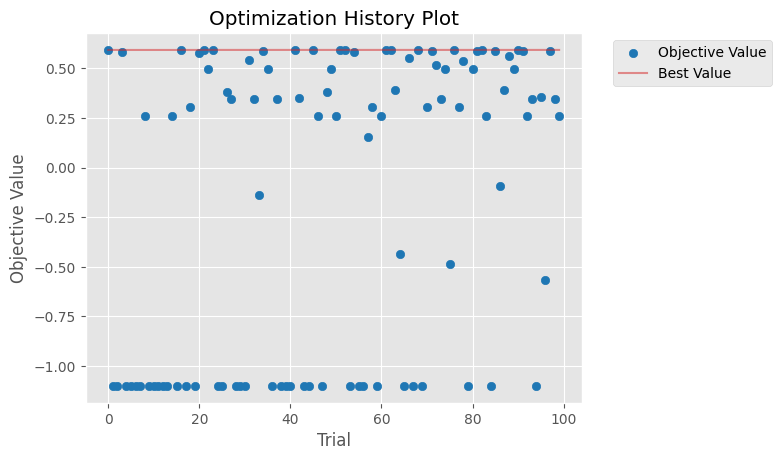

In [39]:
plot_optimization_history(study)

#### At the bottom are the trails the were aborted with -1.1. We can see that almost imdediatly we got the best result, and we could have theoretically stop the test right there.

### parallel coordinate 

/tmp/ipykernel_522845/4291280223.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


<Axes: title={'center': 'Parallel Coordinate Plot'}>

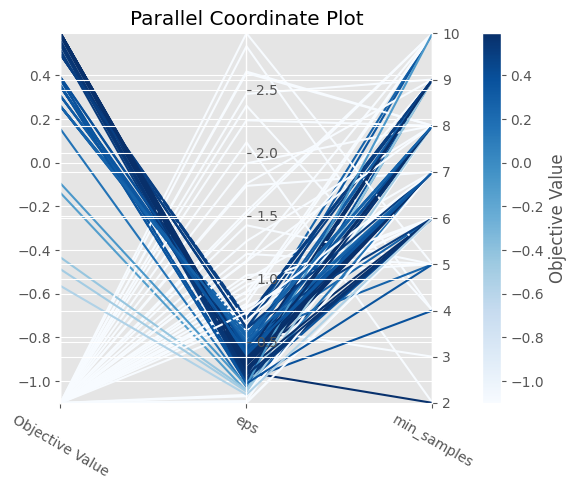

In [41]:
plot_parallel_coordinate(study)

#### This graph show for every silhouette score the epsilon we used. Indeed we see that most of the higher silhouette scores are around the area of 0.5.

### contour plot (for 2d)

/tmp/ipykernel_522845/927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-08-27 18:37:32,936] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='eps', ylabel='min_samples'>

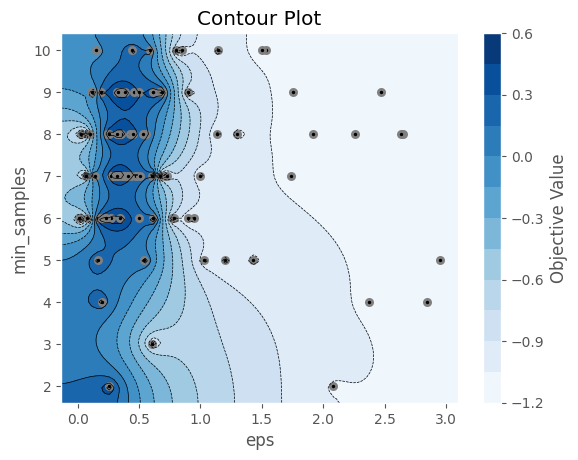

In [42]:
plot_contour(study)

#### where the the depper the blue, the better the function.

### Feature importance

/tmp/ipykernel_522845/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

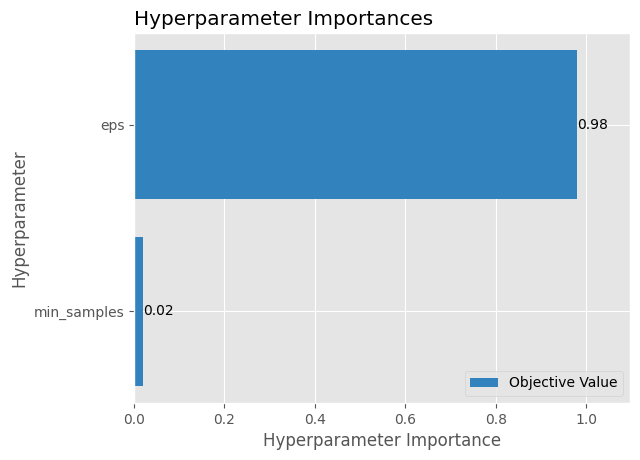

In [44]:
plot_param_importances(study)

#### this shows the the parameter "eps" is much more important that the parameter "min_samples".

### Let's now run the DBSCAN with the best parameters:

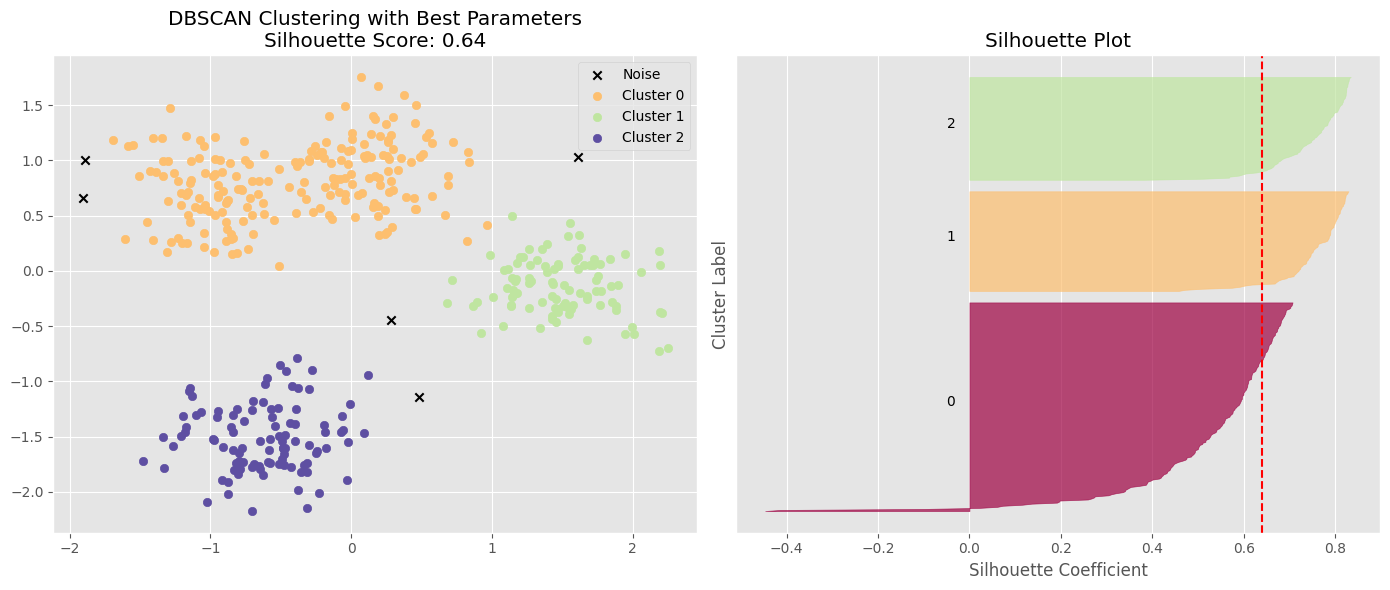

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Best parameters from Optuna
best_params = study.best_params
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']

# Apply DBSCAN with the best parameters
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_std)
labels = db.labels_

# Calculate silhouette scores
mask = labels != -1
silhouette_values = silhouette_samples(X_std[mask], labels[mask])
silhouette_avg = silhouette_score(X_std[mask], labels[mask])

# Plot DBSCAN clustering results
plt.figure(figsize=(14, 6))

# Plot clusters
plt.subplot(1, 2, 1)
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points are labeled as -1 by DBSCAN
        color = 'k'
        marker = 'x'
    else:
        marker = 'o'
    
    class_member_mask = (labels == label)
    xy = X_std[class_member_mask]
    
    plt.scatter(xy[:, 0], xy[:, 1], c=[color], marker=marker, label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title(f'DBSCAN Clustering with Best Parameters\nSilhouette Score: {silhouette_avg:.2f}')
plt.legend()

# Plot silhouette scores
plt.subplot(1, 2, 2)
y_lower = 10
for i, label in enumerate(np.unique(labels[mask])):
    ith_cluster_silhouette_values = silhouette_values[labels[mask] == label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.Spectral(float(i) / len(np.unique(labels[mask])))
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
    
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')
plt.yticks([])

plt.tight_layout()
plt.show()


#### We got a lot less noise than in our first trail, and it seems we found the best solution with DBSCAN.